In [ ]:
from google.colab import files
uploaded=files.upload()

Saving data.csv to data.csv


In [ ]:
import pandas as pd
data=pd.read_csv("data.csv")
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


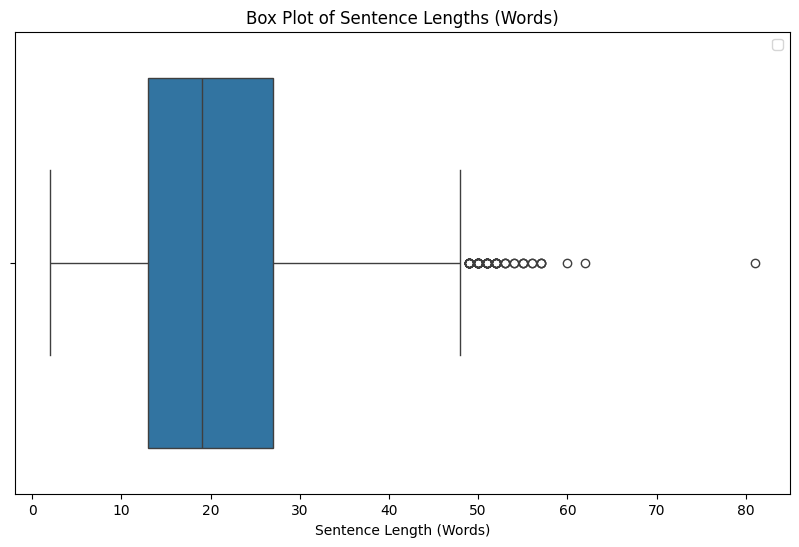

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the length of each sentence in terms of words
sequence_lengths = [len(seq.split()) for seq in data["Sentence"]]

# Visualize the sentence lengths using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=sequence_lengths)
plt.title('Box Plot of Sentence Lengths (Words)')
plt.xlabel('Sentence Length (Words)')
plt.legend()
plt.show()


In [ ]:
!pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.1 MB/s eta 0:00:00


Base line Model

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools
from gensim.models import Word2Vec
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary resources from nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('also')

# Define punctuation characters to be removed (excluding common currency symbols)
currency_symbols = '$€£¥₹'
punctuation_to_remove = string.punctuation.replace('$', '').replace('€', '').replace('£', '').replace('¥', '').replace('₹', '')

# Function to preprocess text by lowercasing, removing punctuation, and lemmatizing
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(f"[{re.escape(punctuation_to_remove)}]", '', text)  # Remove unwanted punctuation
    words = text.split()  # Tokenize by splitting on spaces
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return filtered_words
# Assuming data['Sentence'] contains the text data as a list of sentences
texts_lower = [preprocess_text(sentence) for sentence in data['Sentence']]  # Preprocess all sentences

# Initialize Word2Vec model
word2vec_model = Word2Vec(vector_size=50, window=5, sg=0, negative=2, min_count=1)

# Build the vocabulary and train Word2Vec
word2vec_model.build_vocab(texts_lower)
word2vec_model.train(texts_lower, total_examples=word2vec_model.corpus_count, epochs=30)

# Convert sentences to sequences of word vectors
vectorized_sentences = []
for sentence in texts_lower:
    vectorized_sentence = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    vectorized_sentences.append(vectorized_sentence)

# Define the maximum sequence length for LSTM input
max_sequence_length = 30  # Adjust based on your dataset and text length

# Pad sequences to ensure uniform input length for the LSTM
X = pad_sequences([np.array(sentence) for sentence in vectorized_sentences],
                  maxlen=max_sequence_length,
                  padding='post',
                  dtype='float32')

# Encode the labels (assuming binary or multiclass classification)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Sentiment'])  # Assuming 'Sentiment' column exists in `data`
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels for multi-class classification

# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the LSTM model for text classification
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.5189 - loss: 1.0134 - val_accuracy: 0.5277 - val_loss: 0.9360
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5469 - loss: 0.9197 - val_accuracy: 0.5864 - val_loss: 0.9053
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.6020 - loss: 0.8838 - val_accuracy: 0.5801 - val_loss: 0.9011
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.5971 - loss: 0.8812 - val_accuracy: 0.5819 - val_loss: 0.8910
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6097 - loss: 0.8765 - val_accuracy: 0.5995 - val_loss: 0.8807
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.5973 - loss: 0.8592 - val_accuracy: 0.5916 - val_loss: 0.8799
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.6155 - loss: 0.8573 - val_accuracy: 0.5898 - val_loss: 0.8754
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.6045 - loss: 0.8562 - val_accuracy: 0

include stop words and no Lemmatization

In [ ]:

import re# Function to preprocess text by lowercasing and removing punctuation (keeping stopwords)
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(f"[{re.escape(punctuation_to_remove)}]", '', text)  # Remove unwanted punctuation
    words = text.split()  # Tokenize by splitting on spaces
    return words  # Return tokenized words, keeping stopwords

# Assuming data['Sentence'] contains the text data as a list of sentences
texts_lower = [preprocess_text(sentence) for sentence in data['Sentence']]  # Preprocess all sentences

# Initialize Word2Vec model
word2vec_model = Word2Vec(vector_size=50, window=5, sg=0, negative=2, min_count=1)

# Build the vocabulary and train Word2Vec
word2vec_model.build_vocab(texts_lower)
word2vec_model.train(texts_lower, total_examples=word2vec_model.corpus_count, epochs=30)

# Convert sentences to sequences of word vectors
vectorized_sentences = []
for sentence in texts_lower:
    vectorized_sentence = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    vectorized_sentences.append(vectorized_sentence)

# Define the maximum sequence length for LSTM input
max_sequence_length = 30  # Adjust based on your dataset and text length

# Pad sequences to ensure uniform input length for the LSTM
X = pad_sequences([np.array(sentence) for sentence in vectorized_sentences],
                  maxlen=max_sequence_length,
                  padding='post',
                  dtype='float32')

# Encode the labels (assuming binary or multiclass classification)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Sentiment'])  # Assuming 'Sentiment' column exists in data
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels for multi-class classification

# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the LSTM model for text classification
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.5371 - loss: 0.9789 - val_accuracy: 0.6212 - val_loss: 0.8947
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.6073 - loss: 0.8635 - val_accuracy: 0.6264 - val_loss: 0.8457
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.6258 - loss: 0.8313 - val_accuracy: 0.6229 - val_loss: 0.8392
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.6448 - loss: 0.8112 - val_accuracy: 0.6389 - val_loss: 0.8326
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.6417 - loss: 0.7995 - val_accuracy: 0.6338 - val_loss: 0.8156
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6407 - loss: 0.7994 - val_accuracy: 0.6275 - val_loss: 0.8055
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.6500 - loss: 0.7693 - val_accuracy: 0.6349 - val_loss: 0.8081
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.6532 - loss: 0.7759 - val_accuracy: 

Word Embeddings

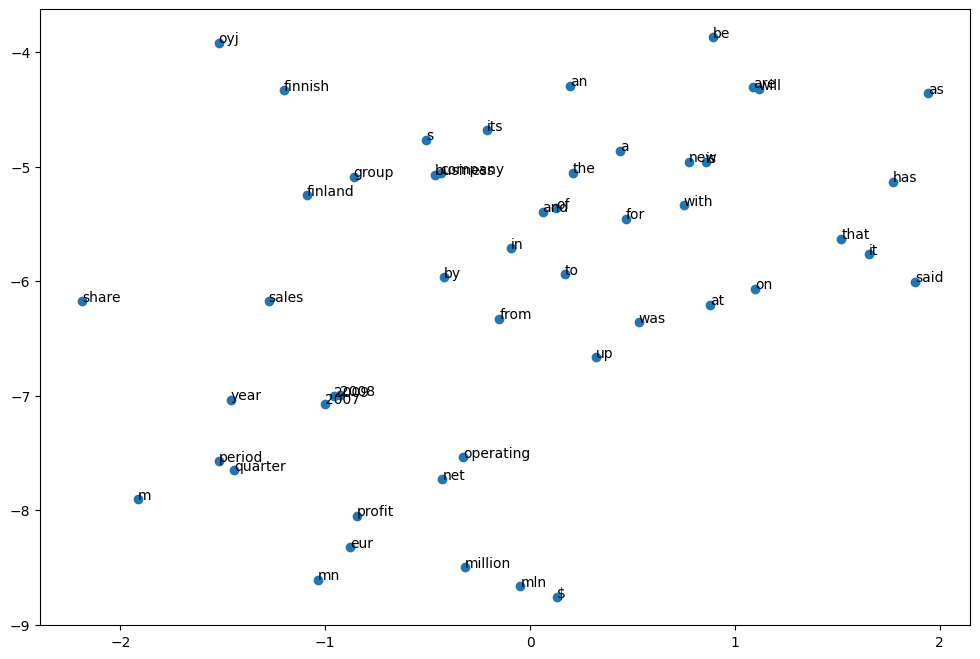

In [ ]:

# Get the list of words and their corresponding vectors
words = list(word2vec_model.wv.index_to_key)  # Get all the words in the vocabulary

# Select a subset of words (e.g., the first 50 words for simplicity)
# You can change this to a more complex selection logic, such as filtering by frequency, word similarity, or a specific topic.
selected_words = words[:50]  # Select the first 50 words for visualization

# Get vectors only for the selected words
selected_word_vectors = np.array([word2vec_model.wv[word] for word in selected_words])

# Use t-SNE to reduce dimensionality of word vectors to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(selected_word_vectors)

# Plot the reduced vectors using matplotlib
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

# Annotate the points with the corresponding words
for i, word in enumerate(selected_words):
    word = word.replace('$', r'\$')  # Escape dollar signs if present
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))

# Show the plot
plt.show()

Hyper parameter Tuning for word2vec and LSTM parameters

In [ ]:
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools

# Define hyperparameter search spaces for Word2Vec and LSTM
word2vec_params = {
    'vector_size': [200, 300],
    'window': [10, 25],
    'negative': [10, 20],
}

lstm_params = {
    'lstm_units': [64, 128, 256],
    'dropout_rate_lstm': [0.4, 0.5],  # LSTM dropout rate
    'dropout_rate_dense': [0.2, 0.4]  # Dense layer dropout rate
}

# Combine the parameters for Word2Vec and LSTM
combinations = itertools.product(
    word2vec_params['vector_size'],
    word2vec_params['window'],
    word2vec_params['negative'],
    lstm_params['lstm_units'],
    lstm_params['dropout_rate_lstm'],
    lstm_params['dropout_rate_dense']
)

# Track the best model and its score
best_score = float('-inf')
best_params = None

# Function to handle OOV words with a dedicated 'UNK' vector
def get_word_vector(word, model, vector_size, unk_vector=None):
    if word in model.wv:
        return model.wv[word]
    else:
        if unk_vector is None:
            return np.random.uniform(-0.25, 0.25, vector_size)
        else:
            return unk_vector

# Iterate over each combination of hyperparameters
for vector_size, window, negative, lstm_units, dropout_rate_lstm, dropout_rate_dense in combinations:
    print(f"Training with combination: vector_size={vector_size}, window={window}, "
          f"negative={negative}, lstm_units={lstm_units}, "
          f"dropout_rate_lstm={dropout_rate_lstm}, dropout_rate_dense={dropout_rate_dense}")

    # Train Word2Vec model
    word2vec_model = Word2Vec(
        vector_size=vector_size,
        window=window,
        sg=1,
        negative=negative,
        epochs=30
    )

    word2vec_model.build_vocab(texts_lower)
    word2vec_model.train(texts_lower, total_examples=word2vec_model.corpus_count, epochs=30)

    unk_vector = np.mean(word2vec_model.wv.vectors, axis=0)

    vectorized_sentences = [[get_word_vector(word, word2vec_model, vector_size, unk_vector) for word in sentence] for sentence in texts_lower]

    # Pad sequences
    max_sequence_length = 30  # Set max sequence length based on your data
    X = pad_sequences([np.array(sentence) for sentence in vectorized_sentences], maxlen=max_sequence_length, padding='post', dtype='float32')

    # Encode the labels and split data into training and test sets
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Sentiment'])  # Ensure 'data' contains 'Sentiment'
    y = tf.keras.utils.to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Build and compile LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dropout(dropout_rate_lstm),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate_dense),
        tf.keras.layers.Dense(y.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100, verbose=1, callbacks=[early_stopping])

    _, accuracy = model.evaluate(X_test, y_test, verbose=1)

    if accuracy > best_score:
        best_score = accuracy
        best_params = {
            'vector_size': vector_size,
            'window': window,
            'negative': negative,
            'lstm_units': lstm_units,
            'dropout_rate_lstm': dropout_rate_lstm,
            'dropout_rate_dense': dropout_rate_dense
        }

# Print the best parameters and accuracy score
print(f"Best Accuracy: {best_score:.4f}")
print(f"Best Parameters: {best_params}")



Training with combination: vector_size=200, window=10, negative=10, lstm_units=64, dropout_rate_lstm=0.4, dropout_rate_dense=0.2
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5172 - loss: 1.0219 - val_accuracy: 0.5357 - val_loss: 0.9259
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5670 - loss: 0.8923 - val_accuracy: 0.6189 - val_loss: 0.8383
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6275 - loss: 0.8327 - val_accuracy: 0.6435 - val_loss: 0.7924
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6461 - loss: 0.7822 - val_accuracy: 0.6794 - val_loss: 0.7591
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6785 - loss: 0.7317 - val_accuracy: 0.6800 - val_loss: 0.7264
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.6972 - loss: 0.6900 - val_accuracy: 0.6771 - val_loss: 0.7121
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7275 - loss: 0.6330 - val_accuracy: 0.7039 

Optimized Model with the selected parameters from Hyperparamter Tuning and unknow words handling but no Lemmatization

In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 34.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools
from gensim.models import Word2Vec
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import numpy as np

# Download necessary resources from nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('also')

# Define punctuation characters to be removed (excluding common currency symbols)
currency_symbols = '$€£¥₹'
punctuation_to_remove = string.punctuation.replace('$', '').replace('€', '').replace('£', '').replace('¥', '').replace('₹', '')

# Initialize the spell checker and lemmatizer
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()

# Function to preprocess text by lowercasing, removing punctuation, lemmatizing, and checking spelling
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(f"[{re.escape(punctuation_to_remove)}]", '', text)  # Remove unwanted punctuation
    words = text.split()  # Tokenize by splitting on spaces
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return filtered_words  # Return tokenized, meaningful, and lemmatized list of words

# Assuming data['Sentence'] contains the text data as a list of sentences
texts_lower = [preprocess_text(sentence) for sentence in data['Sentence']]  # Preprocess all sentences

# Initialize Word2Vec model (now correctly added)
word2vec_model = Word2Vec(vector_size=300, window=25, sg=1, negative=20, min_count=1)

# Function to handle OOV words with a dedicated 'UNK' vector
def get_word_vector(word, model, vector_size, unk_vector=None):
    if word in model.wv:
        return model.wv[word]
    else:
        # Return the 'UNK' vector (learned during training) or initialize a random one
        if unk_vector is None:
            return np.random.uniform(-0.25, 0.25, vector_size)
        else:
            return unk_vector

# Build the vocabulary and train Word2Vec
word2vec_model.build_vocab(texts_lower)
word2vec_model.train(texts_lower, total_examples=word2vec_model.corpus_count, epochs=30)

# Optionally define an 'UNK' vector as the average of all word vectors
unk_vector = np.mean(word2vec_model.wv.vectors, axis=0)

# Convert sentences to sequences of word vectors
vectorized_sentences = []
for sentence in texts_lower:
    vectorized_sentence = [get_word_vector(word, word2vec_model, 350, unk_vector) for word in sentence]
    vectorized_sentences.append(vectorized_sentence)

# Define the maximum sequence length for LSTM input
max_sequence_length = 30  # Adjust based on your dataset and text length

# Pad sequences to ensure uniform input length for the LSTM
# Padding will ensure that all sentences have the same length
X = pad_sequences([np.array(sentence) for sentence in vectorized_sentences],
                  maxlen=max_sequence_length,
                  padding='post',
                  dtype='float32')

# Encode the labels (assuming binary or multiclass classification)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Sentiment'])  # Assuming 'Sentiment' column exists in `data`
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels for multi-class classification


# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the LSTM model for text classification
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100,callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.5351 - loss: 0.9941 - val_accuracy: 0.6138 - val_loss: 0.8666
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.6151 - loss: 0.8584 - val_accuracy: 0.6087 - val_loss: 0.8540
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 0.6391 - loss: 0.7980 - val_accuracy: 0.6418 - val_loss: 0.7940
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.6636 - loss: 0.7636 - val_accuracy: 0.6572 - val_loss: 0.7692
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.7042 - loss: 0.6893 - val_accuracy: 0.6492 - val_loss: 0.7493
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.7059 - loss: 0.6563 - val_accuracy: 0.6794 - val_loss: 0.7688
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.7204 - loss: 0.6433 - val_accuracy: 0.6805 - val_loss: 0.7067
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.7316 - loss: 0.5928 - val_accu